## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

*Write your collaboration/references here*

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [32]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  242k  100  242k    0     0   957k      0 --:--:-- --:--:-- --:--:--  957k


The cell below will download the dataset from S3 to us-congress-tweets directory

In [33]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

mkdir: cannot create directory ‘us-congress-tweets’: File exists
--2022-03-07 01:52:21--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.235.57
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.235.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0s      

2022-03-07 01:52:21 (78.6 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-07 01:52:21--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.174.177
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.174.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914 (

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [38]:
# create a Spark session
conf = SparkConf().set("spark.ui.port", "4050")

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


ValueError: ignored

In [39]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
congress_members.show()
print("Number of congress members tracked:", congress_members.count())

+------------------+---------------+
|            userid|    screen_name|
+------------------+---------------+
|         776664410|  RepCartwright|
|         240363117|   RepTomMarino|
|837722935095930883| RepScottTaylor|
|        1069124515|     RepLaMalfa|
|818460870573441028|  RepTomGarrett|
|         163570705|     repcleaver|
|          19739126|      GOPLeader|
|          33563161| RepJoseSerrano|
|        2861616083|USRepGaryPalmer|
|        1074518754| SenatorBaldwin|
|         305620929|  Call_Me_Dutch|
|         381152398| RepTerriSewell|
|         834069080| RepDavidRouzer|
|         249787913|  SenatorCarper|
|         188019606|        Clyburn|
|         217543151|SenatorTimScott|
|          39249305| USRepMikeDoyle|
|          33537967|   amyklobuchar|
|         249410485|  SanfordBishop|
|          23124635|    TomColeOK04|
+------------------+---------------+
only showing top 20 rows

Number of congress members tracked: 576


We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [40]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [41]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [42]:
# your code here for unique users
from pyspark.sql.functions import col, countDistinct

tweets.filter(col("user_id").isNotNull()).select("user_id").distinct().show()
print("Unique Users",tweets.select("user_id").distinct().count())



+-------------------+
|            user_id|
+-------------------+
|           34000351|
|          171896156|
|           27975417|
|          403723130|
| 766689785595453440|
|           56111948|
|         2191370758|
|         4421683829|
|           17202713|
|1037322807955349504|
| 996112494803402752|
|          636714033|
|          505826307|
| 826898616782561280|
|         3192787583|
|           64709572|
|          324460754|
|          353996415|
| 828627047534587905|
|          543649046|
+-------------------+
only showing top 20 rows

Unique Users 198098


b) How many times is the user **GOPLeader** mentioned?


In [43]:
# code here

from pyspark.sql.functions import col
from pyspark.sql.functions import array_contains
ans = tweets.where(array_contains("entities.user_mentions.screen_name", "GOPLeader")).count()
print("GOPLeader mentioned: ",ans)

GOPLeader mentioned:  4728


c) Now find the top-5 most mentioned members of Congress.

In [45]:
# code here
# a = tweets.select(F.col("entities.user_mentions.id").alias("Id"),F.explode("entities.user_mentions.screen_name")\
#                   .alias("mentions")).groupby("mentions").count()
# #filtering only members of congress
# ans = a.join(congress_members,congress_members.screen_name==a.mentions)
# ans.sort(F.col('count').desc()).show(5)
a = tweets.select(explode(tweets.entities.user_mentions.id).alias('Id')).groupby('Id').agg({'Id':'count'}).select(col('Id'),col('count(Id)').alias('frequency'))
a.join(congress_members,congress_members.userid == a.Id,'inner').sort(col('frequency').desc()).select('screen_name','frequency').show(5)


+---------------+---------+
|    screen_name|frequency|
+---------------+---------+
|    NancyPelosi|    16135|
|   senatemajldr|    15021|
|LindseyGrahamSC|    14412|
|     SenSchumer|    13738|
|  RepAdamSchiff|    13288|
+---------------+---------+
only showing top 5 rows



d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [46]:
# code here

from pyspark.sql.functions import *
from pyspark.sql.window import Window

a = tweets.withColumn('month', month('created_at'))\
                                        .select('month', explode(tweets.entities.user_mentions.screen_name).alias('user_mentions'))

b = a.groupby('month', 'user_mentions').agg({'user_mentions': 'count'}).select('*', col('count(user_mentions)').alias('frequency'))\
                                                                  .select('user_mentions', 'frequency', 'month')
                                                              
curr = b.select('*',rank().over(Window.partitionBy(b['month']).orderBy(b['frequency'].desc())).alias('rank')).filter(col('rank')<=5)

ans = curr.select('*').orderBy(curr['month'].asc(),curr['frequency'].desc()).show(20)


+---------------+---------+-----+----+
|  user_mentions|frequency|month|rank|
+---------------+---------+-----+----+
|realDonaldTrump|     4154|    1|   1|
|  SpeakerPelosi|     3318|    1|   2|
|     SenSchumer|     2797|    1|   3|
|   senatemajldr|     2577|    1|   4|
|LindseyGrahamSC|     1818|    1|   5|
|     marcorubio|     1883|    2|   1|
|realDonaldTrump|     1807|    2|   2|
|  RepAdamSchiff|     1172|    2|   3|
|  SpeakerPelosi|     1141|    2|   4|
|     SenSanders|     1083|    2|   5|
|  RepAdamSchiff|     2301|    3|   1|
|realDonaldTrump|     1906|    3|   2|
|LindseyGrahamSC|     1570|    3|   3|
|     marcorubio|     1494|    3|   4|
|  SpeakerPelosi|     1120|    3|   5|
|  RepAdamSchiff|     1843|    4|   1|
|realDonaldTrump|     1410|    4|   2|
|  SpeakerPelosi|     1206|    4|   3|
|     SenSchumer|      967|    4|   4|
| RepJerryNadler|      924|    4|   5|
+---------------+---------+-----+----+
only showing top 20 rows



e) Do you notice anything interesting in your monthly analysis?

Some interesting facts we can observe include:


1.   President Trump is mentioned the most and is ranked high even in top 5 for each month.
2.   Other most mentioned people include Nancy Pelosi and Lindsey Graham.



## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [47]:
# your network construction code here
from graphframes import *
from pyspark.sql.functions import *
user_mentions = spark.read.csv("us-congress-tweets/user_mentions.csv", header=True)

vertices = user_mentions.select('src').union(user_mentions.select('dst')).distinct().select(col('src').alias('id'))

edges = user_mentions

G = GraphFrame(vertices,edges)
G.vertices.show()
G.edges.show()


+-------------------+
|                 id|
+-------------------+
|          508996900|
|           53589935|
|           30191308|
|         1325721486|
|1025446910218227712|
|         1434240264|
|          985456944|
|1022001889423044610|
| 885326729778253824|
|         4356169936|
|          779204136|
|         1534791056|
| 918883537671122945|
|          154197726|
|         1077650310|
|          196429298|
| 829701100001492994|
|           22372268|
|           99194817|
| 958549180355551232|
+-------------------+
only showing top 20 rows

+------------------+------------------+-----+
|               src|               dst|count|
+------------------+------------------+-----+
|917194889275699201|        1249982359|    1|
|917570582555779072|         251918778|    1|
|         633674091|         432895323|   48|
|913222391416934402|         432895323|  261|
|         217574712|          47203904|    1|
|931278145679847424|         320757267|    1|
|897332217646522368|          92

How many vertices are there in your network? And how many edges?

In [48]:
# your code
print('Number of Vertices: ',G.vertices.count())
print('Number of Edges:', G.edges.count())

Number of Vertices:  1133350
Number of Edges: 2064872


Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [ ]:
# your PageRank code here (should be pretty short since you're just calling a function)
ranks = G.pageRank(resetProbability=0.15, maxIter=10)

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [ ]:
# Top 10 accounts 
ranks.vertices.sort(F.desc("pagerank")).limit(10).show()


What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users

Yes all of them are congress members.

## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


In [ ]:
from pyspark.sql.functions import isnan
temp = tweets.select(F.col("entities.hashtags.text"),F.col("user.screen_name").alias("name"))
temp = temp.withColumn("textcount", F.size(F.col("text")))
total = temp.select('*').where(F.col("textcount")>=1).count()
print(total)

max_hashtag = temp.agg(max("textcount")).show()
temp.select('*').where(F.col("textcount")==16).show()



One intresting thing is that top 5 most mentioned users haven't used any hastags in their tweets. 

Out of 4M users only 34624 tweets have hashtags.
Maximum number of hashtags used are 16 and the user is not from US congress.


## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D (that is, A links to B and to D)
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

Answer:



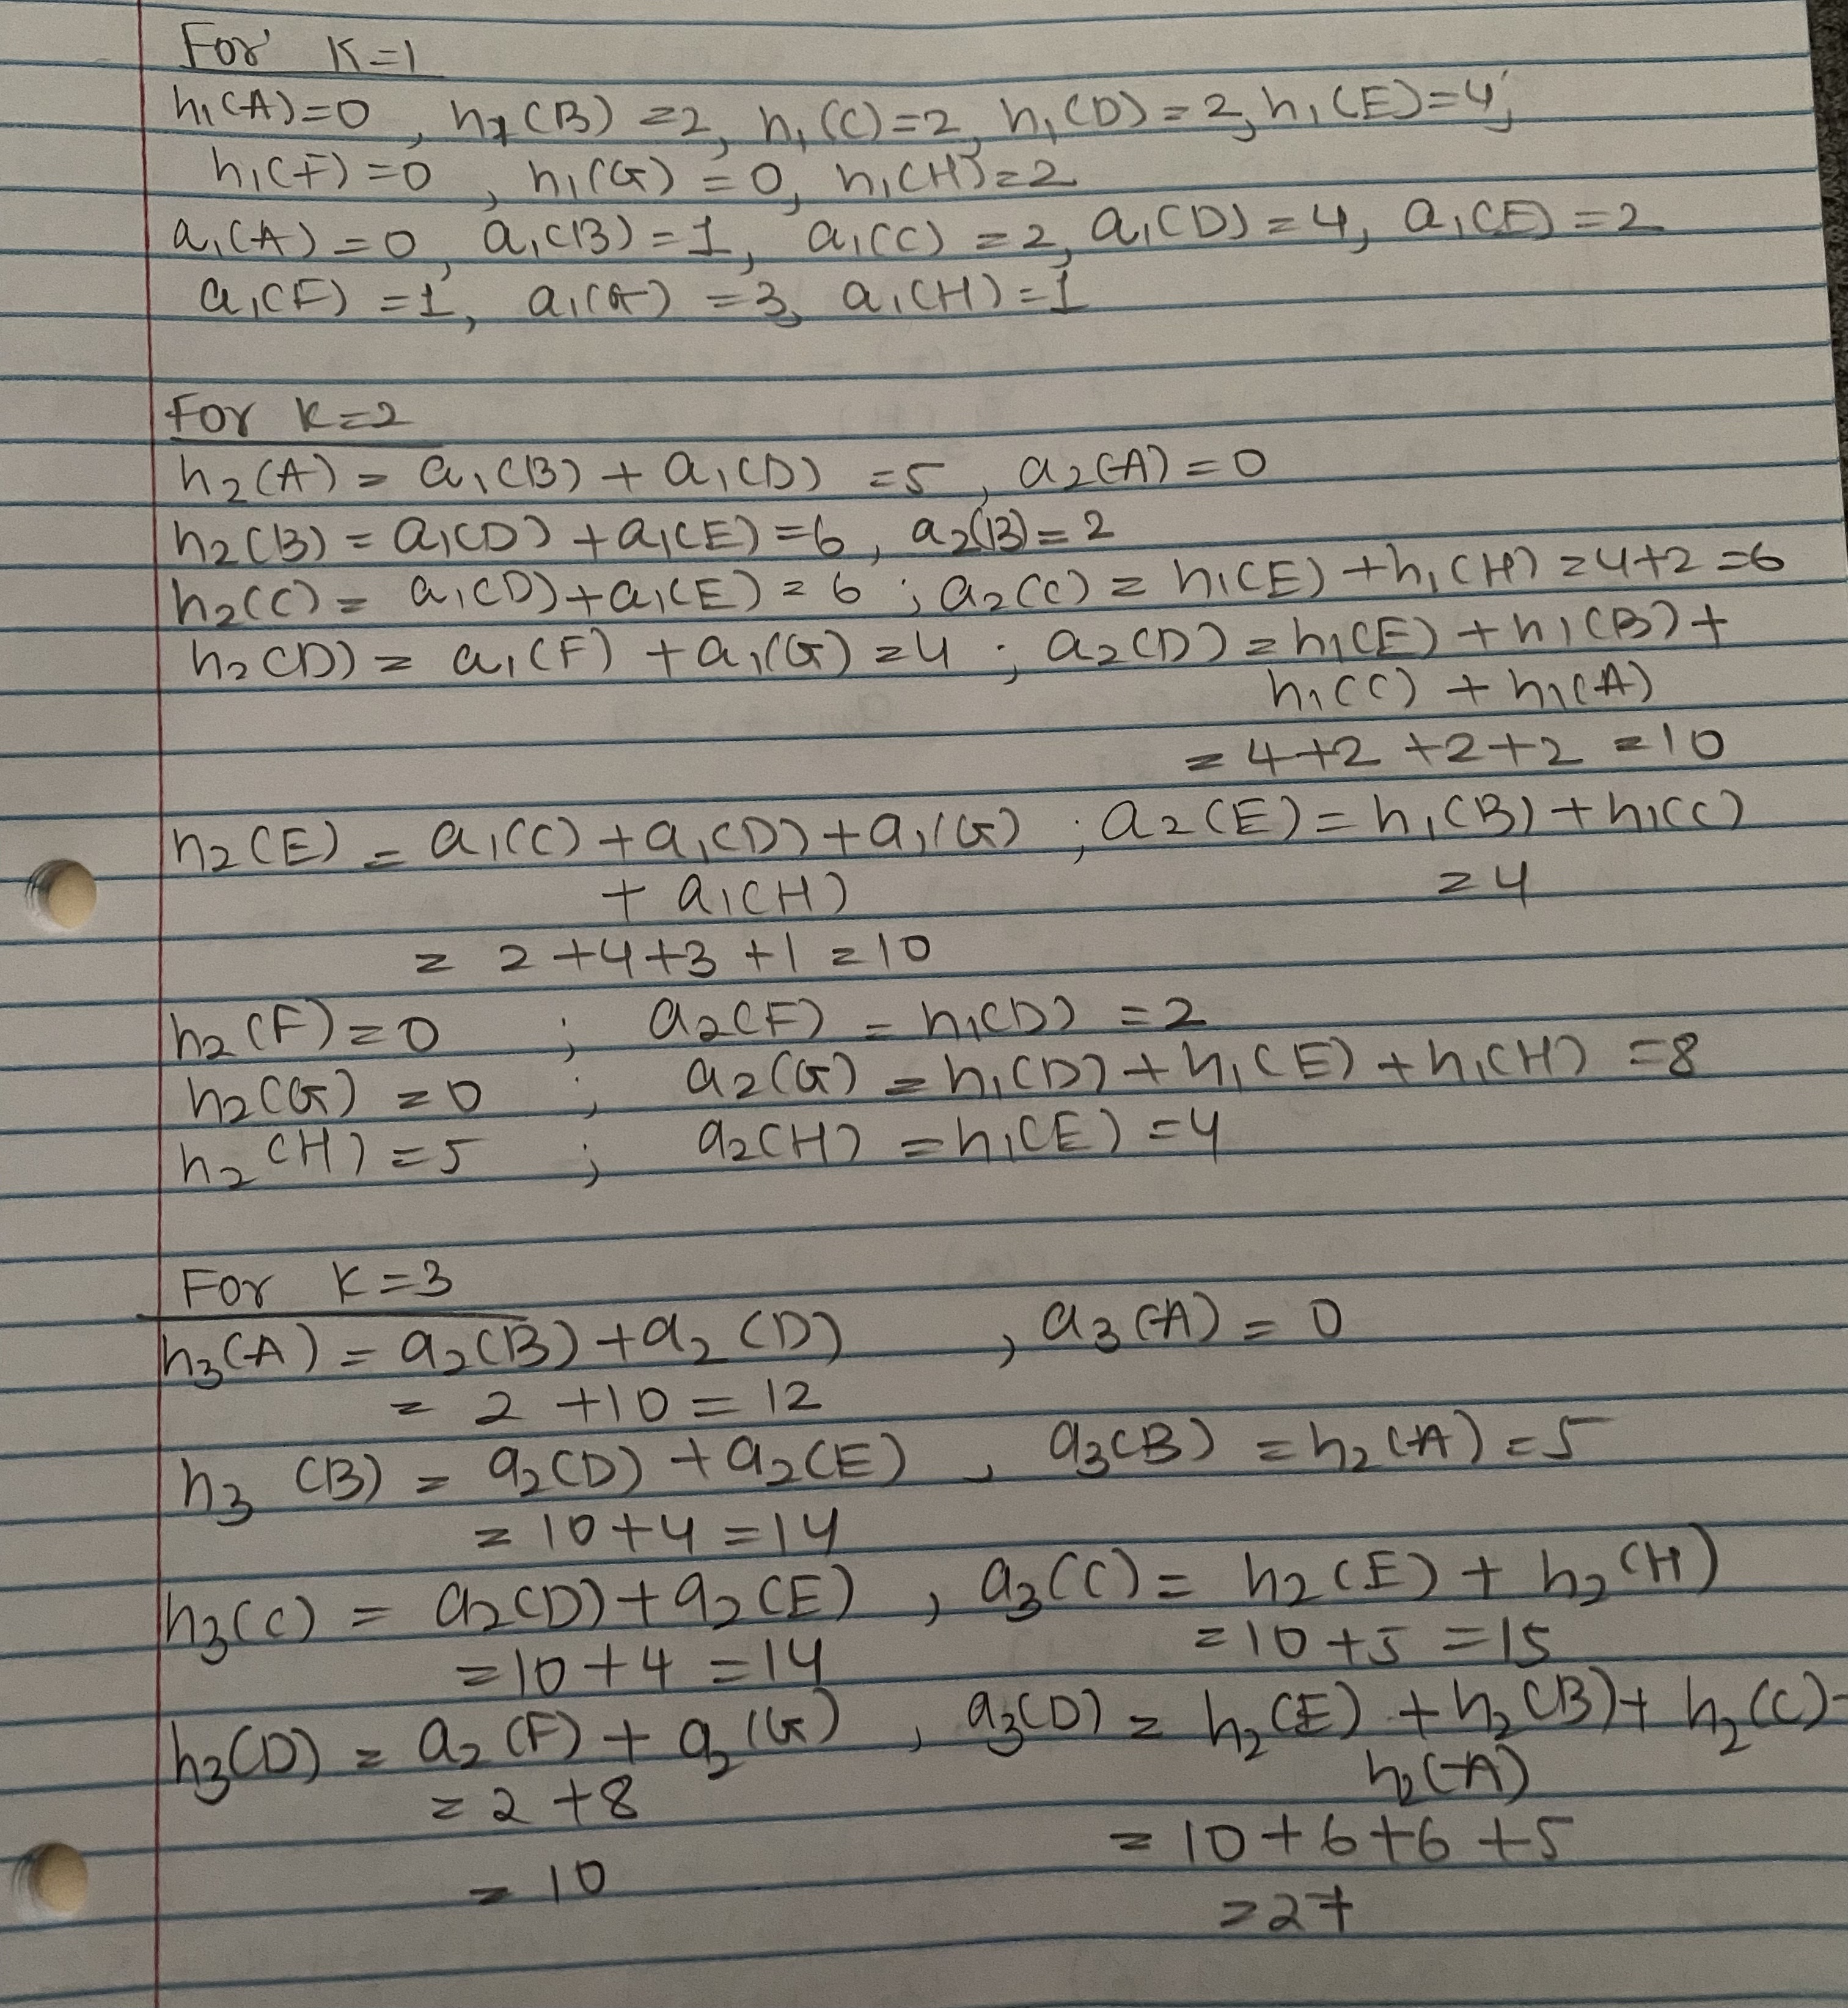

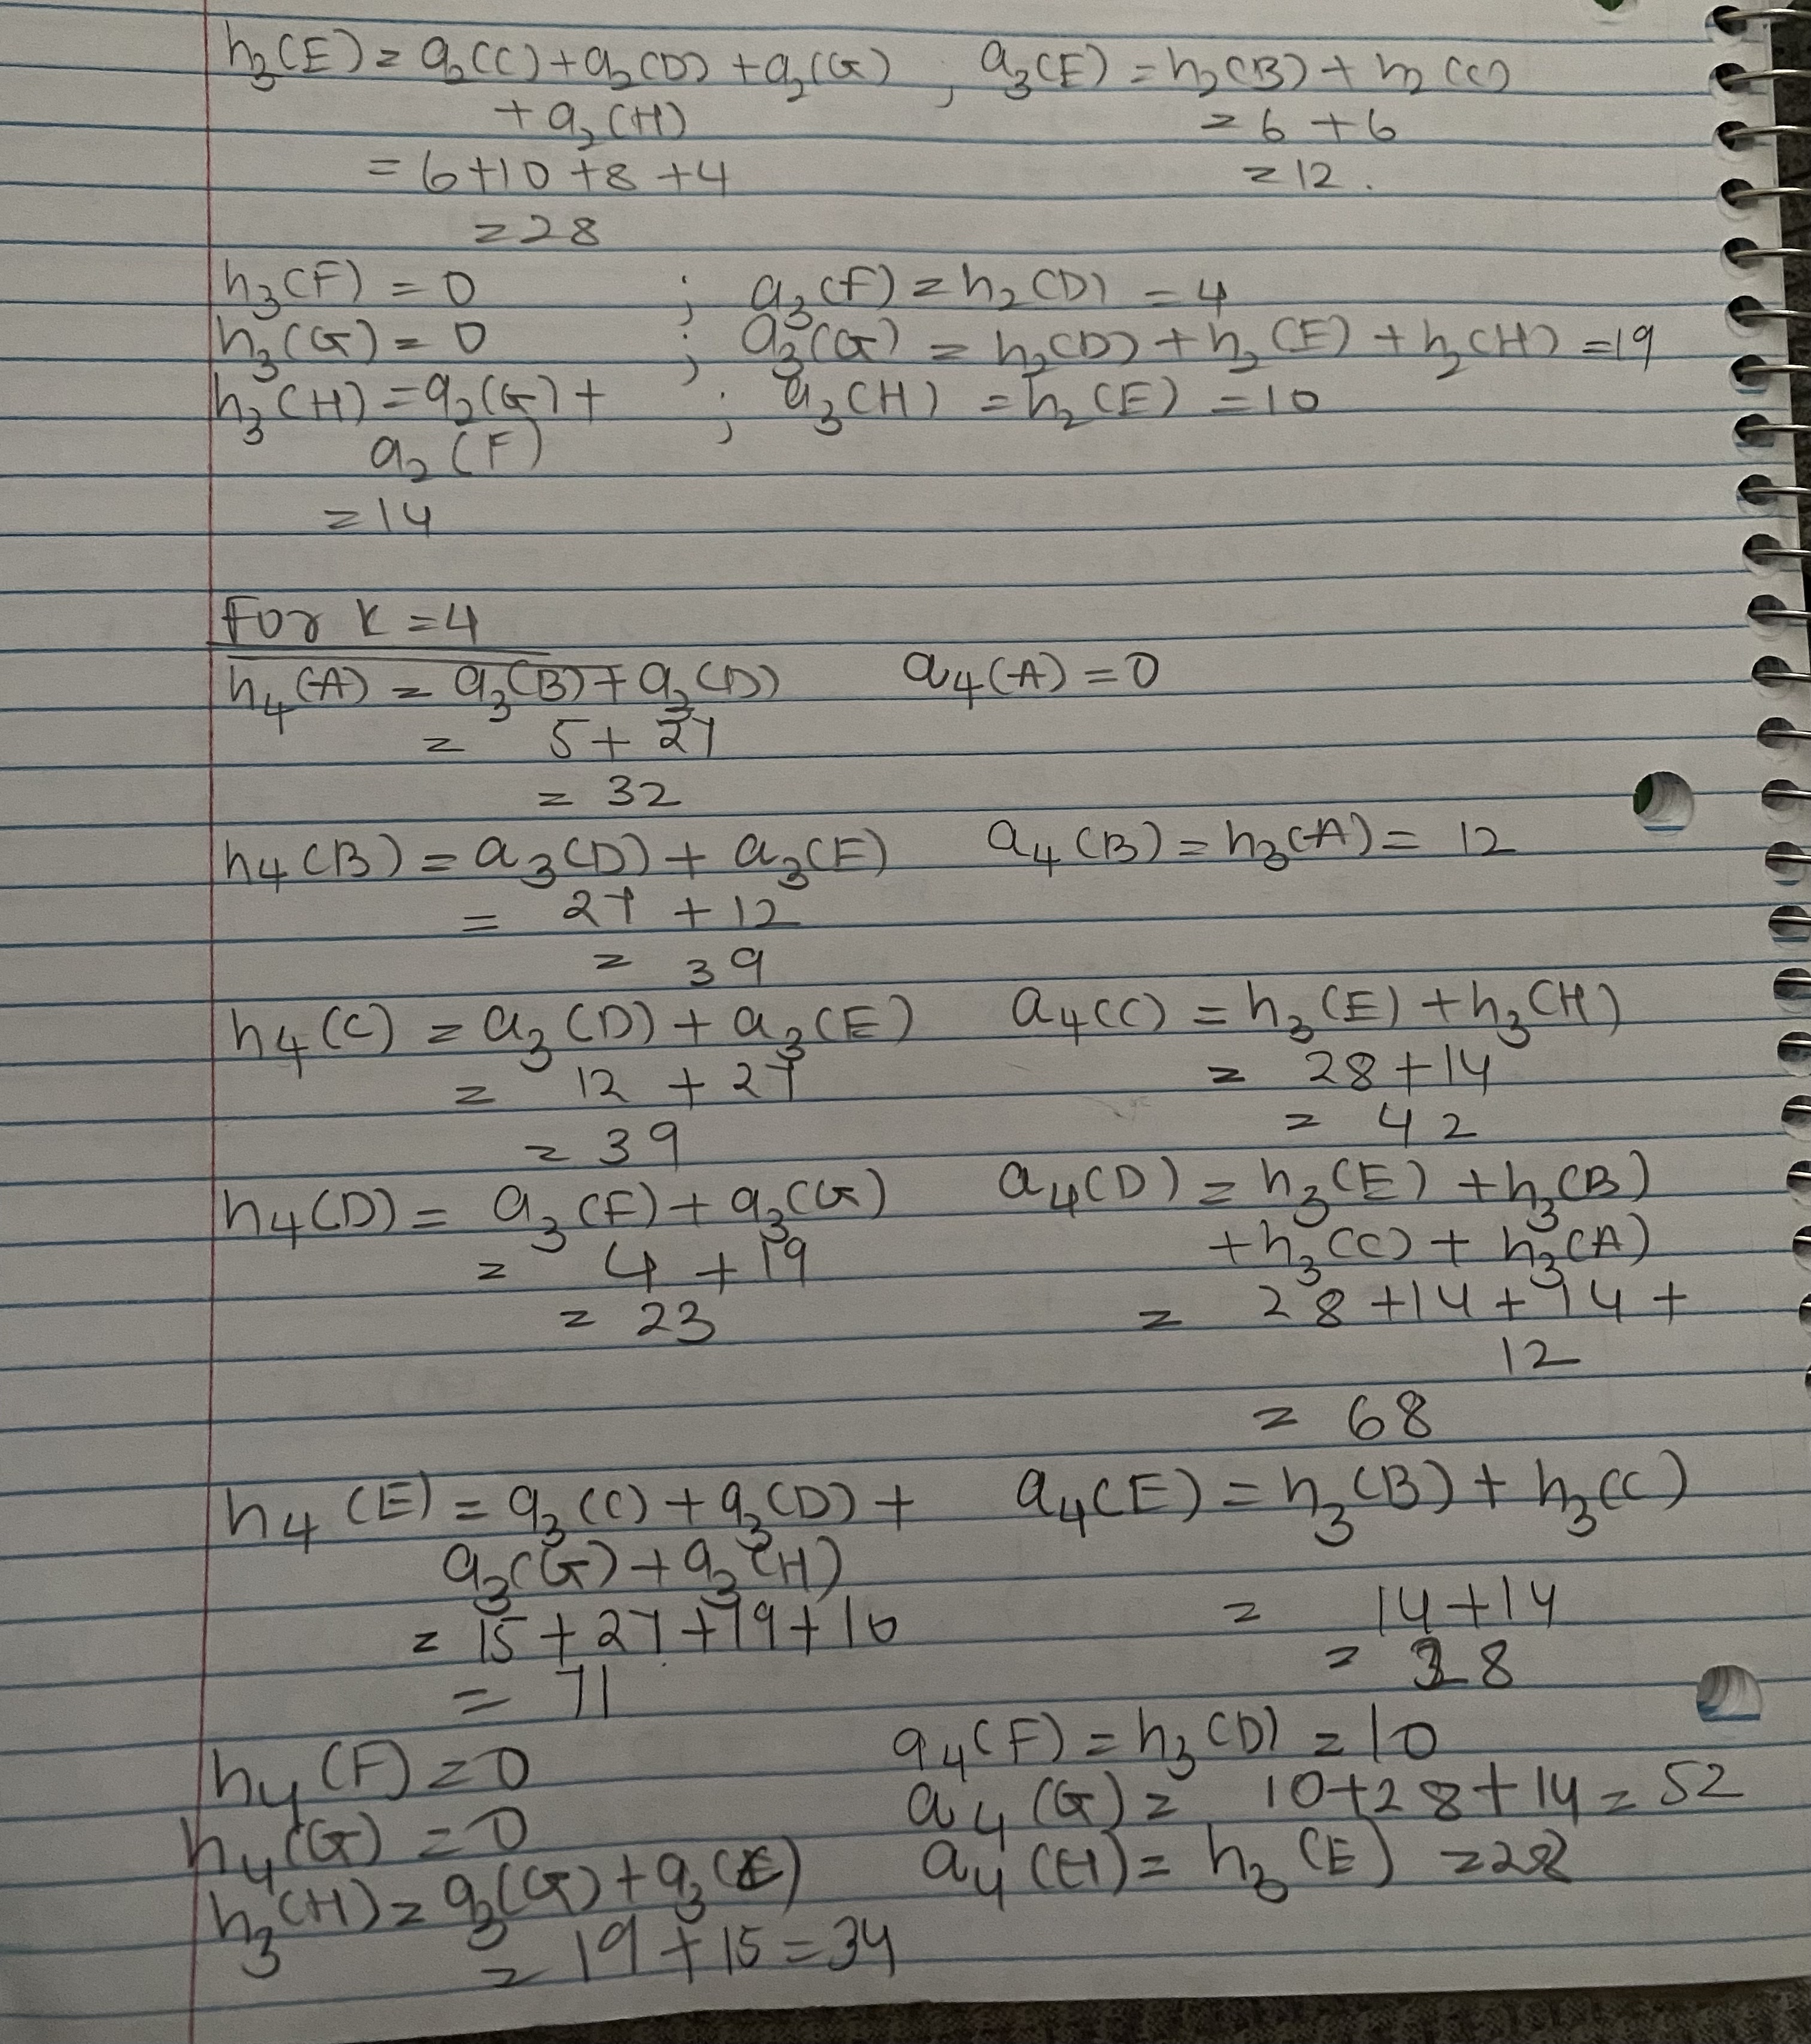


For k  = 1
\begin{array}{|c|c|} \hline
Nodes & Hubs & Authority \\ \hline
A & 2 & 0 \\
B & 2 & 1\\
C & 2 & 2\\
D & 2 & 4\\
E & 4 & 2\\
F & 0 & 1\\
G & 0 & 3\\
H & 2 & 1\\ \hline
\end{array}

For k = 2
\begin{array}{|c|c|} \hline
Nodes & Hubs & Authority \\ \hline
A & 5 & 0 \\
B & 6 & 2\\
C & 6 & 6\\
D & 4 & 10\\
E & 10 & 4\\
F & 0 & 2\\
G & 0 & 8\\
H & 5 & 4\\ \hline
\end{array}

For k = 3 
\begin{array}{|c|c|} \hline
Nodes & Hubs & Authority \\ \hline
A & 12 & 0 \\
B & 14 & 5\\
C & 14 & 15\\
D & 10 & 27\\
E & 28 & 12\\
F & 0 & 4\\
G & 0 & 19\\
H & 14 & 10\\ \hline
\end{array}

For k = 4 (Normalized)
\begin{array}{|c|c|} \hline
Nodes & Hubs & Authority \\ \hline
A & 0.1344 & 0 \\
B & 0.1638 & 0.05\\
C & 0.1638 & 0.17\\
D & 0.0966 & 0.28 \\
E & 0.2983 & 0.12\\
F & 0 & 0.04\\
G & 0 & 0.22\\
H & 0.1428 &0.12\\ \hline
\end{array}

## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 


##Exercise 3.1.2

Let A =  {1, 1, 1, 2}, B = {1, 1, 2, 2, 3} and C = {1, 2, 3, 4}

Jaccard similarity of A and B = |{1,1,2}|/|{1,1,2,2,3}| = 3/9 = 1/3

Jaccard similarity of A and C = |{1,2}|/|{1,1,1,2,3,4}| = 2/8 = 1/4

Jaccard similarity of B and C = |{1,2,3}|/|{1,1,2,2,3,4}| = 3/9 = 1/3

##Exercise 3.2.2
Shingles: "The most effective", "most effective way", "way to represent", "to represent documents", "as sets, for", "for the purpose", "the purpose of", "of identifying lexically", "is to construct", "to construct from", "the document the", "the set of", "of short strings".


##Exercise 3.3.3
\begin{array}{|c|c|} \hline
 S1 & S2 & S3&S4&(2x+1)mod6 & (3x+2)mod6& (5x+2)mod6\\ \hline
0& 1& 0 & 1&1&2&2\\
0&1&0&0&3&5&1\\
1&0&0&1&5&2&2\\
0&0&1&0&1&5&5\\
0&0&1&1&3&2&4\\
1&0&0&0&5&5&3 \\\hline
\end{array}

   Minhash signature
\begin{array}{|c|c|} \hline
Elements & S1 & S2 & S3&S4 \\ \hline
h1(0) & \infty & 1&\infty&1\\
h2(0)&\infty&2&\infty&2\\
h3(0)&\infty&2&\infty&2\\
h1(1) & \infty & 1&\infty&1\\
h2(1)&\infty&2&\infty&2\\
h3(1)&\infty&1&\infty&2\\
h1(2) & 5&1&\infty&1\\
h2(2) & 2&2&∞&2\\
h3(2) & 0&1&∞&0\\
h1(3) & 5&1&1&1\\
h2(3) & 2&2&5&2\\
h3(3) & 0&1&5&0 \\ 
h1(4) & 5&1&1&1 \\
h2(4) & 2&2&2&2 \\
h3(4) & 0&1&4&0 \\\hline
\end{array}

Final Matrix
\begin{array}{|c|c|} \hline
Elements & S1 & S2 & S3&S4 \\ \hline
h1(5)& 5 & 1 & 1&1\\
h2(5)&2&2&2&2\\
h3(5) & 0&1&4&0 \\\hline
\end{array}

h3 is the true permutation


#Exercise 3.4.1
*   r = 3, b = 10
\begin{array}{|c|c|} \hline
s & 1-(1-s^{r})^{b} \\ \hline
0.1 & 0.0099 \\
0.2 & 0.0771\\
0.3 & 0.2394\\
0.4 & 0.4838\\
0.5 & 0.7369\\
0.6 & 0.9122\\
0.7 & 0.98501\\
0.8 & 0.99923\\
0.9 & 0.99999 \\ \hline
\end{array}
*   r = 6, b = 20
\begin{array}{|c|c|} \hline
s & 1-(1-s^{r})^{b} \\ \hline
0.1 & 0.000 \\
0.2 & 0.0012\\
0.3 & 0.0144\\
0.4 & 0.0788\\
0.5 & 0.2701\\
0.6 & 0.6154\\
0.7 & 0.9181\\
0.8 & 0.9977\\
0.9 & 0.9999 \\ \hline
\end{array}

*   r = 5, b = 50
\begin{array}{|c|c|} \hline
s & 1-(1-s^{r})^{b} \\ \hline
0.1 & 0.0004 \\
0.2 & 0.0158\\
0.3 & 0.1145\\
0.4 & 0.4022\\
0.5 & 0.7955\\
0.6 & 0.9825\\
0.7 & 0.9998\\
0.8 & 0.9999\\
0.9 & 1.00 \\ \hline
\end{array}


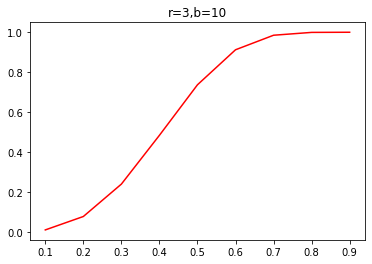

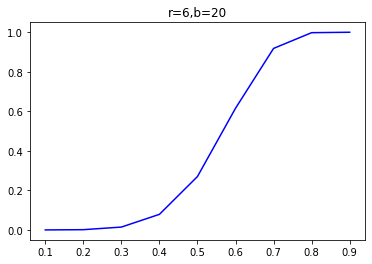

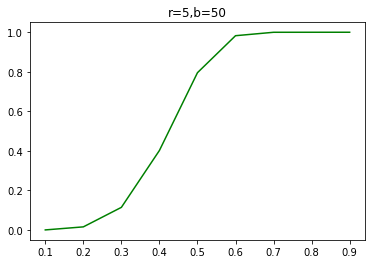

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
y = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
r1 = np.array([0.0099,0.0771,0.2394,0.4838,0.7369,0.9122,0.98501,0.99923,0.99999])
r2 = np.array([0.00,0.0012,0.0144,0.0788,0.2701,0.6154,0.9181,0.9977,0.9999])
r3 = np.array([0.0004,0.0158,0.1145,0.4022,0.7955,0.9825,0.9998,0.9999,1])

plt.title("r=3,b=10")
plt.plot(y, r1, color ="red")
plt.show()

plt.title("r=6,b=20")
plt.plot(y, r2, color ="blue")
plt.show()

plt.title("r=5,b=50")
plt.plot(y, r3, color ="green")
plt.show()


##Exercise 3.4.2

\begin{array}{|c|c|} \hline
(r,b) & s & (1/b)^{1/r} & difference\\ \hline
(3,10) & 0.4061 & 0.4062& 0.058\\
(6,20) & 0.5694&0.607&0.038\\
(5,50) & 0.424& 0.457&0.033\\ \hline
\end{array}

